# Bernstein-Vazirani algorithm

### Juan Luis Salas Montoro

### 24/3/2025

## Introduction

This notebook aims to implement the Bernstein-Vazirani algorithm usig the Qiskit library. This algorithm founds a secret string coded in a function: $f(x)=s·x \, mod(2)$ where $s$ is the secret binary string. The algorithm looks in the superposition of all posible binary numbers given the lenght of the strig and founds $s$ with only one execution.

The algorithm steps are the following:

* Start with all the qubits in state 0 but the last one which is in state 1:

$|\psi\rangle = |0\rangle^{\otimes n} \otimes |1\rangle$

* Apply $\hat{H}$ gates to all qubits in order to get an uniform superposition and the $|-\rangle$ state in the ancilla qubit:

$|\psi\rangle = |+\rangle ^{\otimes n} \otimes |-\rangle = \frac{1}{2^n}\sum_{x=0}^{2^n-1} |x\rangle \otimes |-\rangle$

* Then, we apply the oracle. As the objetive qubit is in $|-\rangle$ state, phase-kickback will occur and change the sign of every $|x\rangle$ state of the superposition depending on $f(x)$ result:

$|\psi\rangle = \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^{f(x)}|x\rangle \otimes |-\rangle = \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^{s·x}|x\rangle \otimes |-\rangle$

* Finally, the last $\hat{H}$ gates are applied. We know that $n$ Hadamard gates applied on a set of $n$ qubits in the state $|y\rangle$ results in:

$\hat{H}^{\otimes n}|y\rangle= \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^{y·x}|x\rangle $

* As the $\hat{H} $ gate is it's own inverse, applying the last $\hat{H}$ gates transform the state into $|s\rangle$:

$\hat{H}^{\otimes n} \frac{1}{2^n}\sum_{x=0}^{2^n-1} (-1)^{s·x}|x\rangle \otimes |-\rangle = |s\rangle \otimes |-\rangle$

We don't care about the auxiliar qubit anymore, so the final state is $|s\rangle \otimes$. If we measure all the cubits, the result must be the secret code.


## Qiskit implementation

I've prepared an example program that takes the secret code as an input and automatically prepares the oracle and the rest of the circuit.

In [1]:
# Importing packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile
from qiskit_aer import Aer

We set a maximum length for the secret code, the maximun qubit count that Qasm Simulator can handle is 29. We will set the maximum length to 28 as we need and extra qubit to run the algorithm.

In [2]:
# Defining some settings
maxlength = 28

The secret string is given by the user as a input. Later, the program generates an oracle capable of implement the function $f(x)$ controlling the auxiliar qubit which is initialized in the state $|1\rangle$. The oracle simply iterate over the secret code an adds a CNOT gate if there is a "1" in the given position. Finally, the oracle is capable of controlling the auxiliar qubit with the result of $s·x\, mod(2)$ operation as every pair of CNOT gates aplied to the auxiliar qubit cancel themselves.

Secret code must be a string of 0 and 1 digits with a maximum length of 28 .
Secret code: 1100110110 loaded succesfully


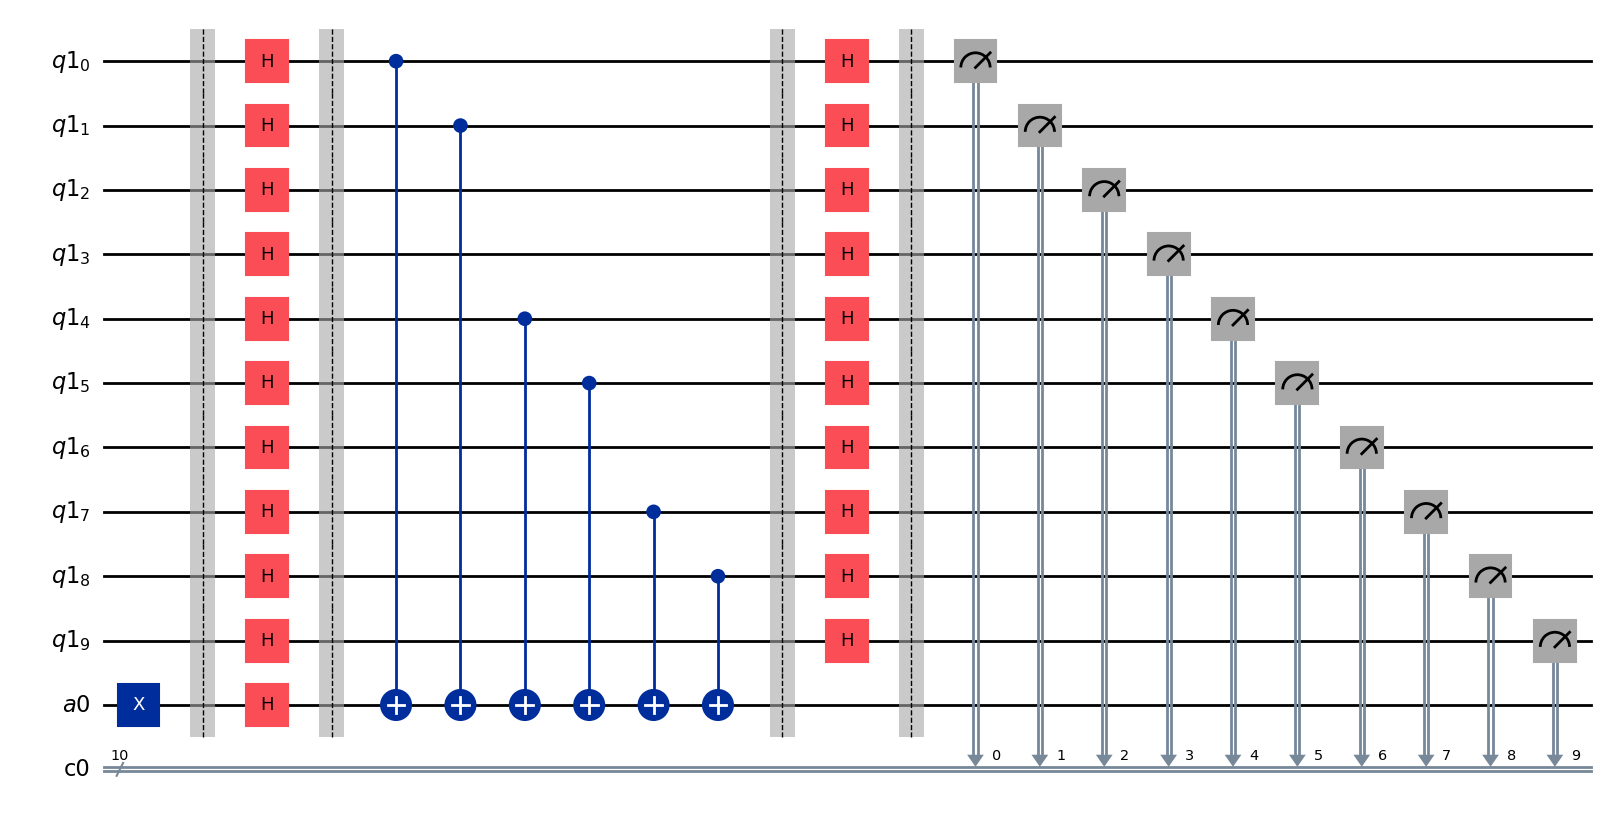

In [3]:
# ======================== Input of the secret code by the user ======================================

print("Secret code must be a string of 0 and 1 digits with a maximum length of", maxlength,".")
secret_code = input("Enter secret code:")

# Getting the secret code length
code_length = len(secret_code)

# Only accept valid codes
if set(secret_code) == {"0","1"} and code_length <= maxlength:

    print("Secret code:", secret_code, "loaded succesfully" )


    # ============================ Quantum circuit creation ======================================

    # Defining the circuit
    qreg = QuantumRegister(code_length)
    areg = AncillaRegister(1)
    creg = ClassicalRegister(code_length)

    qc = QuantumCircuit(qreg, areg, creg)

    # Initialize the ancilla qubit in state |1>
    qc.x(code_length)
    qc.barrier()

    # Apply the first H gates
    qc.h(range(0, code_length+1))
    qc.barrier()

    # Custom oracle implementation

    for i in range(code_length):
        if secret_code[i] == "1":
            qc.cx(i, code_length)
    qc.barrier()

    # Apply the second H gates
    qc.h(range(0, code_length))
    qc.barrier()

    # Measure
    qc.measure(range(0, code_length), range(0, code_length))

    do_draw = input("Want to draw the circuit? y/n").strip().lower()
    if do_draw.startswith("y"):
        display(qc.draw("mpl"))

else:
    print("Please enter a valid code")

Now, we execute the code, we use *shots=1* in the `run()` method as we only need one execution of the circuit.
We obtain a dictionary which contains the simulation results and it appearence rate, as an histogram. As we only usen one shot, there is only a single result. Then, we extract and reverse the result as Quiskit uses little-endian notation.

In [4]:
# Execute the circuit
sim = Aer.get_backend('qasm_simulator')

circuit = transpile(qc, sim)
job = sim.run(circuit, shots=1)

result = job.result()
counts = result.get_counts()
print("Computation result:", counts)

# Obtain the result code string (reverse the string because of little-endian)
result_code = max(counts)[::-1]

Computation result: {'0110110011': 1}


We can see that the algorithm found the secret code in a single iteration.

In [5]:
# Verify if the algorithm found the correct code
if secret_code == result_code:
    print("The algorithm succesfully found the code:", secret_code)
else:
    print("The algorithm hasn't worked")
    print("Secret_code:", secret_code)
    print("Result code:", result_code)

The algorithm succesfully found the code: 1100110110
